In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
stock = yf.Ticker("AMD")

In [3]:
soonest_opt_date = stock.options[0]
stock_price = stock.info['regularMarketPrice']
print(soonest_opt_date)
soonest_option = stock.option_chain(soonest_opt_date)
calls, puts = soonest_option.calls, soonest_option.puts

2021-07-02


In [4]:
call_vals = [0]
total_OI, total_exp_value = calls.openInterest[0], 0
prev_strike = calls.strike[0]
for strike, open_interest in calls[['strike', 'openInterest']].iloc[1:].itertuples(index=False):
    total_exp_value += (total_OI * (strike - prev_strike)) * 100
    #print(f"total val: {total_exp_value}, strike: {strike}, prev strike: {prev_strike}, total OI: {total_OI}")
    prev_strike = strike
    total_OI += open_interest
    call_vals.append(total_exp_value)

calls['exp_val'] = call_vals

In [5]:
put_vals = [0]
total_OI, total_exp_value = puts.openInterest[0], 0
prev_strike = puts.strike.iloc[-1]
for strike, open_interest in puts[['strike', 'openInterest']].iloc[-2::-1].itertuples(index=False):
    total_exp_value += (total_OI * (prev_strike - strike)) * 100
    prev_strike = strike
    total_OI += open_interest
    put_vals.append(total_exp_value)

puts['exp_val'] = put_vals[::-1]

In [6]:
calls_and_puts = pd.concat([calls.strike, calls.exp_val + puts.exp_val], keys=['strike', 'total_exp_val'], axis=1)

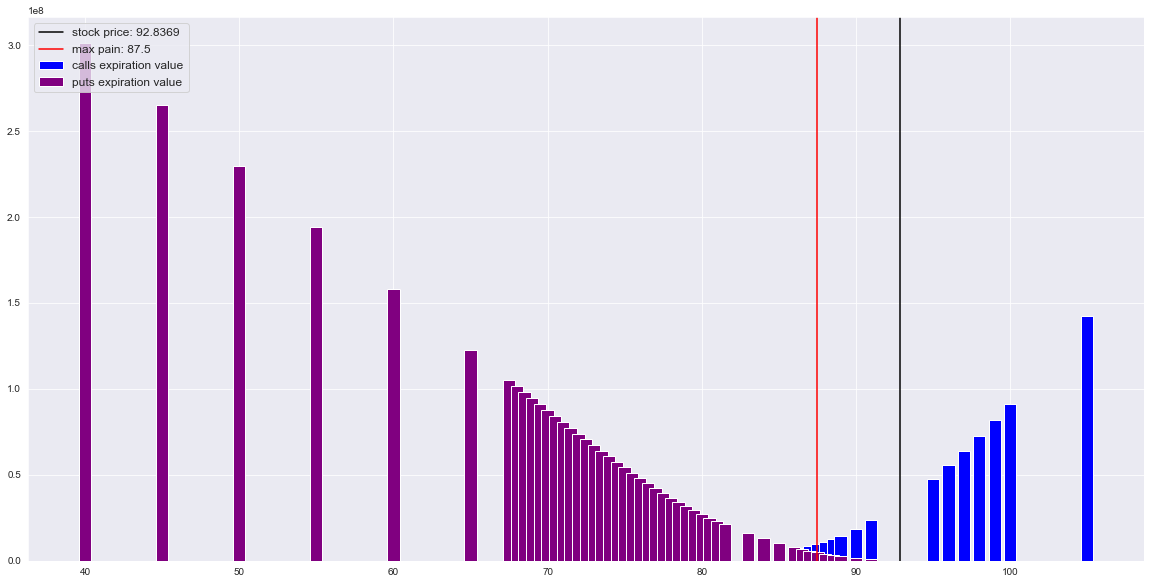

In [7]:
min_exp_val = calls_and_puts.total_exp_val.min()
min_exp_val_strike = calls_and_puts.strike[calls_and_puts.total_exp_val.argmin()]

plt.figure(figsize=(20,10))
plt.bar(calls.strike, calls.exp_val, color='blue', label='calls expiration value')
plt.bar(puts.strike, puts.exp_val, color='purple', label='puts expiration value')
plt.axvline(stock_price, color='black', label=f'stock price: {stock_price}')
plt.axvline(min_exp_val_strike, color='red', label=f'max pain: {min_exp_val_strike}')
plt.legend(fontsize=12, loc='upper left')
plt.show()

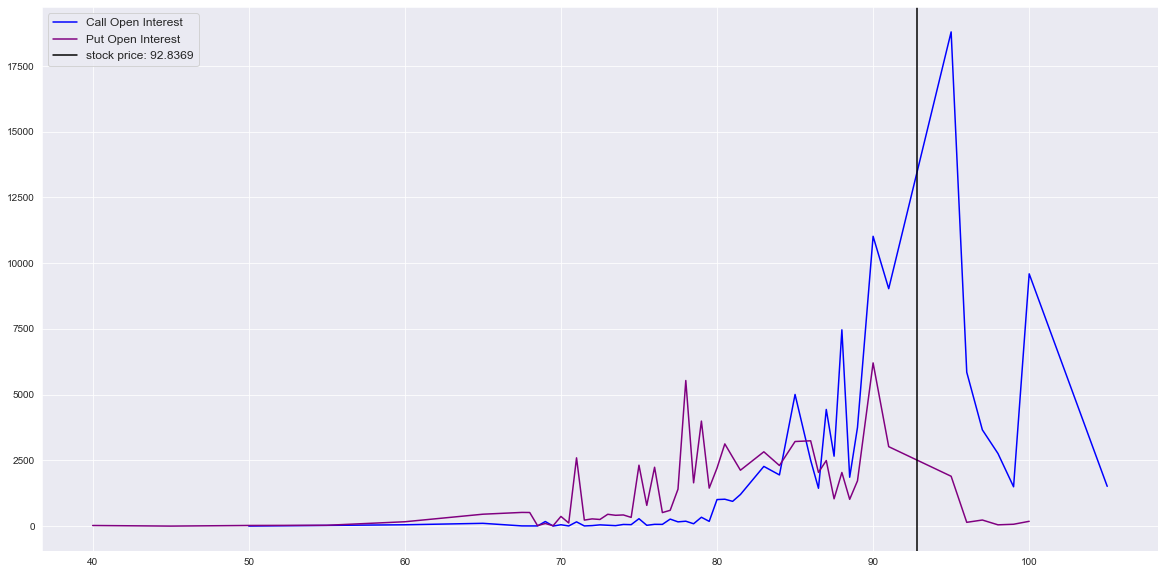

In [8]:
plt.figure(figsize=(20,10))
plt.plot(calls.strike, calls.openInterest, color='blue', label='Call Open Interest')
plt.plot(puts.strike, puts.openInterest, color='purple', label='Put Open Interest')
plt.axvline(stock_price, color='black', label=f'stock price: {stock_price}')
plt.legend(fontsize=12, loc='upper left')
plt.show()

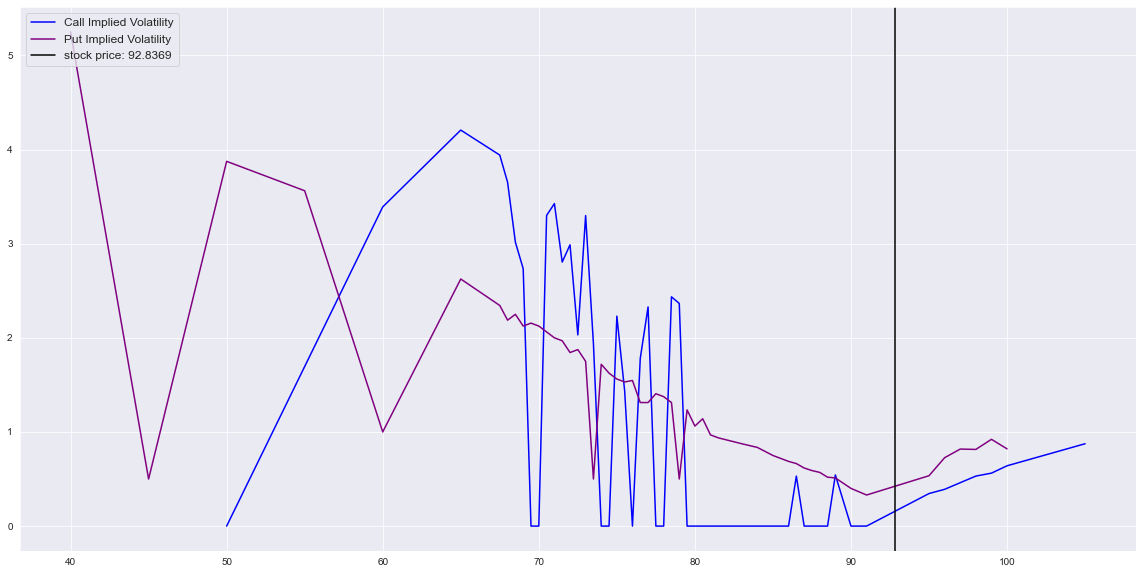

In [9]:
plt.figure(figsize=(20,10))
plt.plot(calls.strike, calls.impliedVolatility, color='blue', label='Call Implied Volatility')
plt.plot(puts.strike, puts.impliedVolatility, color='purple', label='Put Implied Volatility')
plt.axvline(stock_price, color='black', label=f'stock price: {stock_price}')
plt.legend(fontsize=12, loc='upper left')
plt.show()

In [10]:
put_call_ratios = []
option_dates = []

for option_date in stock.options:
    option_chain = stock.option_chain(option_date)
    c, p = option_chain.calls, option_chain.puts

    put_call_ratios.append(p.openInterest.sum() / c.openInterest.sum())
    option_dates.append(option_date)

put_call_ratios = np.array(put_call_ratios)
option_dates = np.array(option_dates)

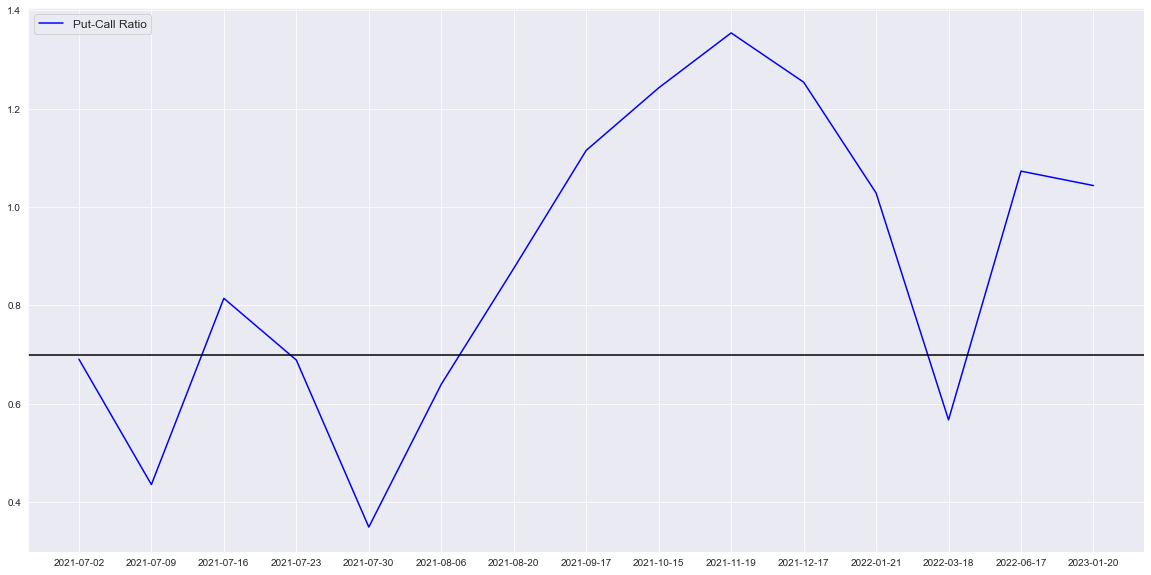

In [11]:
plt.figure(figsize=(20,10))
plt.plot(option_dates, put_call_ratios, color='blue', label='Put-Call Ratio')
plt.axhline(.7, color='black')
plt.legend(fontsize=12, loc='upper left')
plt.show()